# Team Analysis
==========================================================================================

### Thinking
* Players on better teams will play with better players and therefore will perform better
    * Opponents will not be able to focus in on one specific player
* Playing on a team with good defense will only for more offensive snaps
* A good team plays to its strengths: good players will get the ball more
    * Having a smart offensive coordinator or head coach that has a playbook that involves their best players is ideal
* However, a good team may simply just have good players
    * This means that sometimes, your player will perform well regardless of team: they are simply effective 
    * In addition, there is only one ball: stats cannot be shared
        * Playing on a poor team would allow one great player to take in all the stats
    * Does playing on a good team improve or decrease your fantasy production?
    * In reality, this would mainly apply to teams with multiple superstars
   
==========================================================================================
### Data Collection
* Data is available from 2016-2021 (2022, but I don't want to include that data)
* Players have their stats available in this same time period, but advanced stats and defensive aren't tracked until 2018
    * Therefore, I will exclude looking at advanced stats in general in the first bit
    
==========================================================================================
### Method of Analysis
##### Numbers:
* Will calculate the difference of a player's draft position and final standing and its 
    * For example: a player with an ADP (Average Draft Position) of RB12 but finishes the year as the RB5 would be +7
        * Flipping the ADP and Finish would be a -7 rating
        * However, finishing at RB5 from ADP12 is more important than finishing RB24 from ADP31
            * The gap in points is simply too large
            
##### Cleaning + Preparing
* Bring in the data and store in pandas dataframes
    * Need to bring in:
        * ADP (2016-2021Just Overall)
        * Final Seasonal Numbers
        * RedZone Passing, Receiving, Rushing
        * TeamOffense:
            * Conversions
            * Drive averages
            * Passing Offense
            * Rushing Offense
            * Scoring Offense
* Create a Hashing System to link up team names with their abreviations
* Link up player data (Player Team -> Team scoring/passing/receiving/rushing)
* Divide up players by position for comparison
* Scale the numbers (for SVM)

##### Clustering
* Graph a couple of seemingly import attributes
* See if KMeans or MeanShift can cluster the data into groups, may take a long time

##### Modeling
* Will use a SVM and DecisionTree (Maybe RandomForest) to see if there is any trends
* Test on 2022 Seasonal Data while training on these 5-6 years

In [ ]:
### Selecting data to load into list of pandas dataframes
### Don't Click on this, just what was used for cleaning and such
import numpy as np
import pandas as pd
adp = [] #ADP
rnk = [] #End of Season FantasyRankings
rzp = [] #RedZone Passing
rzru = [] #RedZone Rushing
rzre = [] #RedZone Receiving
convs = [] #Conversions
das = [] #driveAverages
pO = [] #passingOffense
rO = [] #rushingOffense
sO = [] #scoringOffense
tO = [] #teamOffense
for i in range(2016, 2022):
    address = "Data/ADP/FantasyPros_" + str(i) + "_Overall_ADP_Rankings.csv"
    temp = pd.read_csv(address, index_col=[1])
    temp.fillna(0, inplace=True)
    adp.append(temp)
    address = "Data/FantasyRankings/" + str(i) + ".csv"
    temp = pd.read_csv(address, index_col=[1])
    temp.fillna(0, inplace=True)
    rnk.append(temp)
    address = "Data/PlayerStats/Passing/redZonePassing/" + str(i) + ".csv"
    temp = pd.read_csv(address, index_col=[0])
    temp.fillna(0, inplace=True)
    rzp.append(temp)
    address = "Data/PlayerStats/Rushing/redZoneRushing/" + str(i) + ".csv"
    temp = pd.read_csv(address, index_col=[0])
    temp.fillna(0, inplace=True)
    rzru.append(temp)
    address = "Data/PlayerStats/Receiving/redZoneReceiving/" + str(i) + ".csv"
    temp = pd.read_csv(address, index_col=[0])
    temp.fillna(0, inplace=True)
    rzre.append(temp)
    address = "Data/TeamOffense/conversions/" + str(i) + ".csv"
    temp = pd.read_csv(address, index_col=[1])
    temp.fillna(0, inplace=True)
    convs.append(temp)
    address = "Data/TeamOffense/driveAverages/" + str(i) + ".csv"
    temp = pd.read_csv(address, index_col=[1])
    temp.fillna(0, inplace=True)
    das.append(temp)
    address = "Data/TeamOffense/passingOffense/" + str(i) + ".csv"
    temp = pd.read_csv(address, index_col=[1])
    temp.fillna(0, inplace=True)
    pO.append(temp)
    address = "Data/TeamOffense/rushingOffense/" + str(i) + ".csv"
    temp = pd.read_csv(address, index_col=[1])
    temp.fillna(0, inplace=True)
    rO.append(temp)
    address = "Data/TeamOffense/scoringOffense/" + str(i) + ".csv"
    temp = pd.read_csv(address, index_col=[1])
    temp.fillna(0, inplace=True)
    sO.append(temp)
    address = "Data/TeamOffense/teamOffense/" + str(i) + ".csv"
    temp = pd.read_csv(address, index_col=[1])
    temp.fillna(0, inplace=True)
    tO.append(temp)
teamdata = []
for i in range(0, 6):
    df = pd.merge(convs[i], das[i], left_index=True, right_index=True)
    df = pd.merge(df, pO[i], left_index=True, right_index=True)
    df = pd.merge(df, rO[i], left_index=True, right_index=True)
    df = pd.merge(df, sO[i], left_index=True, right_index=True)
    df = pd.merge(df, tO[i], left_index=True, right_index=True)
    teamdata.append(df)
for i in range(5):
    address = "Data/Merged/" + str(i+ 2017) + ".csv"
    teamdata[i].to_csv(address)
for i in range(6):
    adp[i] = adp[i][['Player', 'POS', 'AVG']]
    rnk[i].set_index('Player')
    rnk[i] = rnk[i].drop(['Unnamed: 0'], axis=1, inplace=True)
for i in range(6):
    rnk[i]['Player'] = rnk[i]['Player'].str.replace('*', '')
    rnk[i]['Player'] = rnk[i]['Player'].str.replace('+', '')
for i in range(6):
    t1 = adp[i].copy(deep=True)
    t2 = rnk[i].copy(deep=True)
    t3 = rzp[i].copy(deep=True)
    t4 = rzru[i].copy(deep=True)
    t5 = rzre[i].copy(deep=True)

    t1 = t1.join(t2, on='Player')
    t1 = t1.join(t3, on='Player', lsuffix='rank', rsuffix='rzpa')
    t1 = t1.join(t4, on='Player', lsuffix='rzpa', rsuffix='rzru')
    t1 = t1.join(t5, on='Player', lsuffix='rzru', rsuffix='rzre')
    t1.fillna(0, inplace=True)
    address = "Data/MergedPlayers/" + str(i+2016) + ".csv"
    t1.to_csv(address)
for i in range(1,6):
    rnk[i].drop(['Linkrzru', '-9999rzru', 'Tmrzre', '-9999rank', 'Tmrzpa', '-9999rzre', 'Link', 'Linkrzpa', '-9999rzpa', 'Linkrzpa', 'Tmrzru', '-9999rank'], axis=1, inplace=True)
    rnk[i]['POS'] = rnk[i]['POS'].astype('string')
    rnk[i]['Tmrank'] = rnk[i]['Tmrank'].astype('string')
    rnk[i]['FantPos'] = rnk[i]['FantPos'].astype('string')
    rnk[i]['%Tgt'] = rnk[i]['%Tgt'].astype("string")
    rnk[i]['%Tgt'] = rnk[i]['%Tgt'].str.replace('%', '')
    rnk[i]['%Tgt'] = rnk[i]['%Tgt'].astype(float)
    rnk[i]['%Tgt.1'] = rnk[i]['%Tgt.1'].astype("string")
    rnk[i]['%Tgt.1'] = rnk[i]['%Tgt.1'].str.replace('%', '')
    rnk[i]['%Tgt.1'] = rnk[i]['%Tgt.1'].astype(float)
    
    rnk[i]['Ctch%'] = rnk[i]['Ctch%'].astype("string")
    rnk[i]['Ctch%'] = rnk[i]['Ctch%'].str.replace('%', '')
    rnk[i]['Ctch%'] = rnk[i]['Ctch%'].astype(float)
    rnk[i]['Ctch%.1'] = rnk[i]['Ctch%.1'].astype("string")
    rnk[i]['Ctch%.1'] = rnk[i]['Ctch%.1'].str.replace('%', '')
    rnk[i]['Ctch%.1'] = rnk[i]['Ctch%.1'].astype(float)
    rnk[i]['%Rush.2'] = rnk[i]['%Rush.2'].astype("string")
    rnk[i]['%Rush.2'] = rnk[i]['%Rush.2'].str.replace('%', '')
    rnk[i]['%Rush.2'] = rnk[i]['%Rush.2'].astype(float)
    rnk[i]['%Rush.1'] = rnk[i]['%Rush.1'].astype("string")
    rnk[i]['%Rush.1'] = rnk[i]['%Rush.1'].str.replace('%', '')
    rnk[i]['%Rush.1'] = rnk[i]['%Rush.1'].astype(float)
    rnk[i]['%Rush'] = rnk[i]['%Rush'].astype("string")
    rnk[i]['%Rush'] = rnk[i]['%Rush'].str.replace('%', '')
    rnk[i]['%Rush'] = rnk[i]['%Rush'].astype(float)
for i in range(6):
    team[i]['3D%'] = team[i]['3D%'].astype("string")
    team[i]['3D%'] = team[i]['3D%'].str.replace('%', '')
    team[i]['3D%'] = team[i]['3D%'].astype(float)
    
    team[i]['4D%'] = team[i]['4D%'].astype("string")
    team[i]['4D%'] = team[i]['4D%'].str.replace('%', '')
    team[i]['4D%'] = team[i]['4D%'].astype(float)
    
    team[i]['RZPct'] = team[i]['RZPct'].astype("string")
    team[i]['RZPct'] = team[i]['RZPct'].str.replace('%', '')
    team[i]['RZPct'] = team[i]['RZPct'].astype(float)
    
    team[i]['Start'] = team[i]['Start'].astype("string")
    team[i]['Start'] = team[i]['Start'].str.replace('Own ', '')
    team[i]['Start'] = team[i]['Start'].astype(float)
    
    team[i]['Time'] = team[i]['Time'].astype('string')
    team[i]['Time'] = team[i]['Time'].str.replace(':','.')
    team[i]['Time'] = team[i]['Time'].astype(float)
    
    address = "Data/Merged/" + str(i+2016) + ".csv"
    team[i].to_csv(address)
    
def hasher(item):
    return namesHash1[item]

for i in range(4, 6):
    rnk[i]['Tmrank'] = rnk[i]['Tmrank'].to_frame(name='league').applymap(hasher)
COMPLETE = []
for i in range(6):
    t1 = teams[i].copy(deep=True)
    r1 = rnk[i].copy(deep=True)
    df = pd.DataFrame(r1, columns= ['Tmrank_PLAYERS'])
    columns = []
    for i in range(len(t1.columns)):
        empt = []
        for j in range(len(r1)):
            team = df.iloc[j]['Tmrank_PLAYERS']
            if str(team) == "0":
                empt.append(0)
            else:
                empt.append(t1.loc[team][i])
        columns.append(empt)
    for i in range(len(t1.columns)):
        name = t1.columns[i]
        r1.loc[:,name] = columns[i]
    COMPLETE.append(r1)
full = pd.concat(COMPLETE, ignore_index=True)

In [107]:
# Creating a set of the teams
# Due to moving of team and team name changes, this is not as simple as it would seem
namesHash = {"DET": "Detroit Lions",
"GNB": "Green Bay Packers",
"MIN": "Minnesota Vikings",
"JAX": "Jacksonville Jaguars",
"LVR": "Las Vegas Raiders",
"PHI": "Philadelphia Eagles",
"NOR": "New Orleans Saints",
"SFO": "San Francisco 49ers",
"HOU": "Houston Texans",
"MIA": "Miami Dolphins",
"PIT": "Pittsburgh Steelers",
"SEA": "Seattle Seahawks",
"CHI": "Chicago Bears",
"IND": "Indianapolis Colts",
"TEN": "Tennessee Titans",
"NYJ": "New York Jets",
"LAR": "Los Angeles Rams",
"DAL": "Dallas Cowboys",
"2TM": "",
"KAN": "Kansas City Chiefs",
"SDG": "San Diego Chargers",
"3TM": "",
"LAC": "Los Angeles Chargers",
"BUF": "Buffalo Bills",
"BAL": "Baltimore Ravens",
"ATL": "Atlanta Falcons",
"OAK": "Oakland Raiders",
"DEN": "Denver Broncos",
"CLE": "Cleveland Browns",
"NWE": "New England Patriots",
"TAM": "Tampa Bay Buccaneers",
"NYG": "New York Giants",
"CIN": "Cincinnati Bengals",
"ARI": "Arizona Cardinals",
"WAS": "Washington Redskins",
"CAR": "Carolina Panthers",}    
namesHash1 = {"DET": "Detroit Lions",
"GNB": "Green Bay Packers",
"MIN": "Minnesota Vikings",
"JAX": "Jacksonville Jaguars",
"LVR": "Las Vegas Raiders",
"PHI": "Philadelphia Eagles",
"NOR": "New Orleans Saints",
"SFO": "San Francisco 49ers",
"HOU": "Houston Texans",
"MIA": "Miami Dolphins",
"PIT": "Pittsburgh Steelers",
"SEA": "Seattle Seahawks",
"CHI": "Chicago Bears",
"IND": "Indianapolis Colts",
"TEN": "Tennessee Titans",
"NYJ": "New York Jets",
"LAR": "Los Angeles Rams",
"DAL": "Dallas Cowboys",
"2TM": "",
"KAN": "Kansas City Chiefs",
"SDG": "San Diego Chargers",
"3TM": "",
"LAC": "Los Angeles Chargers",
"BUF": "Buffalo Bills",
"BAL": "Baltimore Ravens",
"ATL": "Atlanta Falcons",
"OAK": "Oakland Raiders",
"DEN": "Denver Broncos",
"CLE": "Cleveland Browns",
"NWE": "New England Patriots",
"TAM": "Tampa Bay Buccaneers",
"NYG": "New York Giants",
"CIN": "Cincinnati Bengals",
"ARI": "Arizona Cardinals",
"WAS": "Washington Football Team",
"CAR": "Carolina Panthers",} 

In [224]:
#Loading in team and player data
import numpy as np
import pandas as pd

rnk = []
teams = []
cols=['b', 'g', 'r', 'c', 'm', 'y', 'k','w']
for i in range(2016, 2022):
    address = "Data/Merged/" + str(i) + ".csv"
    temp = pd.read_csv(address, index_col=[0])
    temp.fillna(0, inplace=True)
    temp.columns = [str(col) + '_TEAMS' for col in temp.columns]
    teams.append(temp)
    address = "Data/MergedPlayers/" + str(i) + ".csv"
    temp = pd.read_csv(address, index_col=[0])
    temp.fillna(0, inplace=True)
    temp['POS'] = temp['POS'].astype("string")
    temp['Tmrank'] = temp['Tmrank'].astype("string")
    temp['FantPos'] = temp['FantPos'].astype("string")
    temp = temp[temp['Tmrank'] !="0"]
    temp.columns = [str(col) + '_PLAYERS' for col in temp.columns]
    rnk.append(temp)

In [13]:
#Loading in the combined team and player data
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier 
from sklearn import tree
# Loading in the ultimate combined csv
COMPLETE = []
cols=['b', 'g', 'r', 'c', 'm', 'y', 'k','w']
for i in range(6):
    address = "Data/TEST/" + str(i) + ".csv"
    temp = pd.read_csv(address, index_col=[0])
    COMPLETE.append(temp)
full = pd.concat(COMPLETE, ignore_index=True)

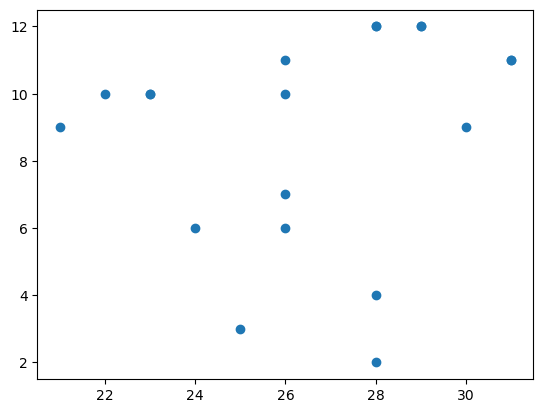

26.526315789473685
2.969631871174001


In [12]:
x = full.loc[(full['Rk_PLAYERS'] < 13) & (full['FantPos_PLAYERS'] == 'WR')]['Age_PLAYERS']
y = full.loc[(full['Rk_PLAYERS'] < 13) & (full['FantPos_PLAYERS'] == 'WR')]['Rk_PLAYERS']
cols=['b', 'g', 'r', 'c', 'm', 'y', 'k','w']
plt.scatter(x, y)
plt.show()
print(x.mean())
print(x.std())

### RunningBacks


##### DecisionTreeRegressor
* Creating a DecisionTreeRegressor, the model is able to accurately predict the points based on factors such as age, targets, attempts and redzone usage
    * The score was around 0.90
        * However, this is not that useful as these stats make up the fantasy score of a player, so not much is learned
    * This model is not very good at predicting whether a player is good value at its draft position
    * Scaling the data does not seem to make a large difference, if any at all
    * Regardless of information fed, the model basiccally is worse than a coinflip if a player is value or not
        * There was wide variation in the results from the score, too much for any conclusive result
        * Narrowing down the data does not seem to help at all
        * Changing the features does improve the score but does not improve consistency
        
##### LinearSVR
* And again, data fit very poorly with the data
* Not much was able to be gathered
* With this, it is likely that at the WR position, this will also hold
* Th

In [98]:
from sklearn import model_selection
from sklearn.tree import DecisionTreeRegressor
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
rbs = full.loc[(full['Pos_PLAYERS'] == 'RB') & (full['FinishRank_PLAYERS'] < 25)]
#rbsT = rbs[['Age_PLAYERS', 'RushAtt_PLAYERS', 'RushYds_PLAYERS', 'RushTD_PLAYERS', 'Tgts_PLAYERS', 'Recs_PLAYERS', 'RecYds_PLAYERS', 'Y/Rec_PLAYERS', 'RecTD_PLAYERS', 'FL_PLAYERS', 'TotalTD_PLAYERS', 'RushAttRZ20_PLAYERS', 'RushYdsRZ20_PLAYERS', 'RushTDRZ20_PLAYERS', '%RushRZ20_PLAYERS', 'RushAttRZ10_PLAYERS', 'RushYdsRZ10_PLAYERS', 'RushTDRZ10_PLAYERS', '%RushRZ10_PLAYERS', 'RushAttRZ5_PLAYERS', 'RushYdsRZ5_PLAYERS', 'RushTDRZ5_PLAYERS', '%RushRZ5_PLAYERS', 'TgtRZ20_PLAYERS', 'RecsRZ20_PLAYERS', 'Ctch%RZ20_PLAYERS', 'RecYdsRZ20_PLAYERS', 'RecTDRZ20_PLAYERS', '%TgtRZ20_PLAYERS', 'TgtRZ10_PLAYERS', 'RecRZ10_PLAYERS', 'Ctch%RZ10_PLAYERS', 'RecYdsRZ10_PLAYERS', 'RecTDRZ10_PLAYERS', '%TgtRZ10_PLAYERS']]
##rbsT = rbs[['Age_PLAYERS', 'RushAtt_PLAYERS', 'RushTD_PLAYERS', 'Tgts_PLAYERS', 'Recs_PLAYERS', 'RecTD_PLAYERS', 'RushAttRZ20_PLAYERS', '%RushRZ20_PLAYERS', 'RushAttRZ10_PLAYERS', '%RushRZ10_PLAYERS', 'RushAttRZ5_PLAYERS', '%RushRZ5_PLAYERS', 'TgtRZ20_PLAYERS', '%TgtRZ20_PLAYERS', 'TgtRZ10_PLAYERS', '%TgtRZ10_PLAYERS']]
##rbsS = rbs[['FantPt_PLAYERS']]
#rbsS.loc[(rbsS['FantPt_PLAYERS'] >= 0), 'score'] = 1
#rbsS.loc[(rbsS['RankDiff_PLAYERS'] < 0), 'score'] = -1
#rbsS = rbsS[['score']]
rbsT = rbs[['3D%_TEAMS', 'TeamTotYds_TEAMS', 'EXP_TEAMS', 'Sc%Drives_TEAMS']]
rbsS = rbs[['FantPt_PLAYERS']]
scaler = MinMaxScaler()
scaler.fit(rbsT)
rbsT = scaler.transform(rbsT)
scaler = MinMaxScaler()
scaler.fit(rbsS)
rbsS = scaler.transform(rbsS)
x_train, x_test, y_train, y_test = model_selection.train_test_split(rbsT, rbsS, test_size=0.2)
clf = DecisionTreeRegressor(max_leaf_nodes=25,random_state=1234)
model = clf.fit(x_train, y_train)
model.score(x_test, y_test)

0.5984988484569325

In [141]:
from sklearn import model_selection
from sklearn.svm import LinearSVR
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
rbs = full.loc[(full['Pos_PLAYERS'] == 'RB') & (full['FinishRank_PLAYERS'] < 10000)]
rbsT = rbs[['3D%_TEAMS', 'TeamTotYds_TEAMS', 'EXP_TEAMS', 'Sc%Drives_TEAMS']]
rbsS = rbs[['RankDiff_PLAYERS']]
rbsS.loc[(rbsS['RankDiff_PLAYERS'] >= 0), 'score'] = 1
rbsS.loc[(rbsS['RankDiff_PLAYERS'] < 0), 'score'] = -1
rbsS = rbsS[['score']]
lsvr = LinearSVR(verbose=0)
#regr = make_pipeline(StandardScaler(),LinearSVR(random_state=0, tol=1e-5))
x_train, x_test, y_train, y_test = model_selection.train_test_split(rbsT, rbsS, test_size=0.2)
model = lsvr.fit(x_train, y_train)
print(model.score(x_test, y_test))

-1.4253928794102992


/var/folders/pw/0cjrcmjj58q0s780404b1jdc0000gn/T/ipykernel_8815/3997748232.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rbsS.loc[(rbsS['RankDiff_PLAYERS'] >= 0), 'score'] = 1
/Users/kahshiuh/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/kahshiuh/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [144]:
from sklearn.preprocessing import StandardScaler 
from sklearn.neural_network import MLPClassifier
rbs = full.loc[(full['Pos_PLAYERS'] == 'RB') & (full['FinishRank_PLAYERS'] < 10000)]
rbsT = rbs[['3D%_TEAMS', 'TeamTotYds_TEAMS', 'EXP_TEAMS', 'Sc%Drives_TEAMS']]
rbsS = rbs[['RankDiff_PLAYERS']]
scaler = StandardScaler()   
x_train, x_test, y_train, y_test = model_selection.train_test_split(rbsT, rbsS, test_size=0.2)
scaler.fit(x_train)  
x_train = scaler.transform(x_train)  
x_test = scaler.transform(x_test) 
scaler = StandardScaler()
scaler.fit(y_train) 
y_train = scaler.transform(y_train)  
y_test = scaler.transform(y_test)
clf = MLPClassifier(hidden_layer_sizes=(15,), random_state=1, max_iter=1, warm_start=True)
for i in range(10):
    clf.fit(x_train, y_train)
clf.score(x_text, y_test)

/Users/kahshiuh/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


ValueError: Unknown label type: (array([-2.27645482e-01, -7.30046304e-01, -2.66851527e-02, -5.58285339e-01,
       -7.47782229e-02,  1.18508845e+00,  1.07172622e+00,  1.29243906e+00,
       -1.60001559e+00,  3.99282040e-01, -1.35753365e-01, -1.47720650e+00,
        2.74755341e-01,  1.64970187e+00,  1.14644224e+00, -1.51585272e+00,
        1.57099080e-01, -4.50934736e-01,  1.02878598e+00,  7.23051459e-01,
       -3.69348278e-01,  3.56341799e-01, -2.19057433e-01, -1.26679932e+00,
        3.80388334e-01, -2.87761819e-01, -2.19057433e-01,  1.84580834e-01,
        1.23232272e+00,  5.23808740e-01,  3.64929847e-01,  7.48815604e-01,
       -6.33001359e-01, -3.36713694e-01, -2.72247350e+00,  1.84580834e-01,
        4.56821964e-01, -5.79755460e-01, -3.15243574e-01,  2.00095304e+00,
        3.06531119e-01, -2.61997675e-01,  1.20655858e+00, -3.96830032e-01,
        6.86981657e-01,  2.81625779e-01, -3.36713694e-01, -8.65737466e-01,
        5.36690812e-01, -4.91298563e-01,  1.16962997e+00,  3.33154069e-01,
        1.47278807e+00, -8.20220811e-01,  1.96903078e-02,  6.44041415e-01,
       -3.30817839e+00,  4.72280450e-01, -6.02943190e-01,  4.01858455e-01,
        1.39064178e-01,  1.16361833e+00,  2.12921393e-01, -4.72964685e-02,
        2.48991196e-01,  1.36114344e+00,  3.01378290e-01, -2.88135239e+00,
        6.82687632e-01, -6.53612675e-01,  1.84636817e+00,  1.18938248e+00,
       -3.34137280e-01, -9.55053168e-01,  3.52047775e-01, -6.57047894e-01,
       -4.16582543e-01,  1.58816689e-01, -6.39871798e-01,  7.53968433e-01,
       -1.58941096e-01,  7.62556481e-01, -9.70511655e-01,  9.10270911e-01,
        6.62935122e-01, -1.69620173e+00,  3.58059409e-01, -2.27645482e-01,
       -1.04780409e+00, -1.58941096e-01,  4.12164113e-01,  3.30577654e-01,
        9.29164617e-01,  9.87563345e-01,  1.30961515e+00,  7.42803970e-01,
       -2.79173771e-01,  3.41742117e-01, -2.40527554e-01, -2.85185405e-01,
        9.01123034e-02, -2.93773453e-01,  7.20475045e-01, -1.27366976e+00,
        3.04813510e-01,  5.88219102e-01, -1.45573638e+00,  1.16705355e+00,
        2.25803466e-01,  9.31741032e-01,  6.43481587e-02,  1.33052545e-01,
       -2.65376911e+00,  7.34215922e-01,  1.16190072e+00,  1.15876448e-01,
       -1.60001559e+00, -8.22797225e-01,  4.83444913e-01, -1.69620173e+00,
       -5.33081023e-02, -1.00915787e+00, -1.87053911e+00,  2.66167293e-01,
        1.91451273e-01,  1.39549564e+00,  4.37928257e-01,  1.82004420e-01,
       -1.03118782e-01,  1.15760670e+00, -1.41966658e+00, -4.87004539e-01,
        7.34215922e-01,  6.62935122e-01, -6.14107653e-01,  1.29243906e+00,
        7.34215922e-01,  1.50714026e+00, -1.62148571e+00,  3.71800286e-01,
        1.42125978e+00, -1.89559093e-02,  1.08203188e+00, -1.46059023e-01,
        6.25147709e-01, -1.15515469e+00,  2.36109124e-01,  6.01101174e-01,
       -1.17233079e+00, -9.47323925e-01,  1.75992786e-01,  1.07288400e-01,
        7.48815604e-01, -2.25927872e-01, -3.65054254e-01,  8.04637918e-01,
        1.01762151e+00, -3.34253058e+00, -5.06757050e-01,  5.19514716e-01,
        8.28684453e-01,  3.53765385e-01, -1.15858991e+00, -1.88999265e-01,
        6.12265637e-01,  1.97089487e+00, -1.56364681e-01,  4.11604284e-02,
       -2.17713243e+00,  8.84506766e-01, -5.71167412e-01, -6.87665891e-02,
       -6.87665891e-02,  1.01762151e+00, -2.43477388e+00,  7.27345483e-01,
        1.16705355e+00, -3.45301743e-01,  4.62833597e-01,  3.53765385e-01,
        3.83823553e-01,  8.02920308e-01,  4.83444913e-01, -3.70580502e+00,
        3.83823553e-01, -1.22987071e+00, -7.99310518e-02,  1.18508845e+00,
        4.67986426e-01,  4.11604284e-02,  1.23232272e+00, -1.35439741e+00,
        9.72104858e-01, -1.07412806e-01,  1.29243906e+00, -1.26679932e+00,
       -2.49115602e-01, -1.19809493e+00,  4.95468181e-01,  1.21888082e-01,
        7.23910264e-01,  5.10926668e-01,  8.86224376e-01, -1.07412806e-01,
       -4.46640712e-01,  8.28684453e-01,  7.89179431e-01, -3.44442938e-01,
       -6.39871798e-01,  8.71624694e-01,  2.15983193e+00,  1.96903078e-02,
        1.78569200e-01, -1.31575119e+00, -6.54471480e-01, -4.93874977e-01,
       -2.31080701e-01,  3.28860045e-01, -1.19809493e+00,  1.10350200e+00,
        1.37574313e+00, -1.12939055e+00,  3.50330165e-01,  6.99863729e-01,
       -7.30046304e-01, -2.16481019e-01, -1.56738101e+00,  2.06909760e-01,
       -4.07994495e-01,  3.51188970e-01,  1.67404738e-01, -2.41087382e-02,
       -5.81473069e-01,  1.76478171e+00, -1.24588903e-01,  9.72104858e-01,
        3.47753751e-01,  1.39064178e-01,  4.37928257e-01,  3.79529529e-01,
        6.28582929e-01,  1.75189964e+00, -2.88392880e+00, -1.02805158e+00,
        8.15242552e-02, -6.33001359e-01,  3.04813510e-01,  8.15242552e-02,
        2.73037731e-01,  1.20054694e+00,  1.20054694e+00, -1.04351007e+00,
       -1.91575679e-01,  2.80393555e+00,  1.12754853e+00,  1.01332749e+00,
       -6.91400087e-01, -4.72964685e-02, -3.34253058e+00,  1.67404738e-01,
        5.10926668e-01,  2.67884902e-01,  5.53866909e-01, -3.04937916e-01,
       -6.93264175e-03,  1.04767968e+00, -1.39562004e+00, -1.25821127e+00,
        3.83823553e-01,  2.74755341e-01,  1.05197371e+00, -2.17713243e+00,
       -2.15323238e-02,  3.67506262e-01, -1.04836392e-01,  3.76094310e-01,
       -3.90818398e-01, -1.29442755e-02,  1.93168882e-01, -7.73546374e-02,
       -7.14587817e-01,  1.96903078e-02,  3.47753751e-01, -2.43219747e+00,
        1.15503029e+00, -5.45403267e-01, -1.77981280e-03, -6.22031532e-05,
        5.25526350e-01, -2.42017420e+00, -1.41764999e-01, -2.52924241e+00,
        1.52805056e-01, -3.90818398e-01,  2.39843319e-02, -2.40527554e-01,
        6.95569705e-01,  3.30577654e-01,  1.07344383e+00,  1.29243906e+00,
       -6.07237214e-01,  5.19514716e-01,  3.00519485e-01,  7.03597925e-02,
        8.04637918e-01,  6.13983247e-01, -1.76490612e+00, -5.66873387e-01,
       -1.79238787e+00, -8.16486615e-02,  7.42803970e-01,  3.08248729e-01,
       -2.52924241e+00,  3.42899898e-02, -9.83393727e-01,  5.62454957e-01,
       -1.06068616e+00, -1.41764999e-01, -3.90818398e-01,  3.06531119e-01,
        4.31057819e-01,  3.41742117e-01,  2.80766975e-01,  4.07870089e-01,
        9.74681273e-01,  1.00731586e+00,  4.85162523e-01,  6.25147709e-01,
       -1.62148571e+00, -1.39562004e+00,  1.07344383e+00,  1.07172622e+00,
       -3.65054254e-01,  4.33634233e-01,  3.83823553e-01,  3.58059409e-01,
        8.86224376e-01, -1.83532811e+00, -1.72797751e+00, -9.70511655e-01,
        7.08451777e-01, -2.16481019e-01,  7.32498312e-01,  1.13527778e+00,
        4.93750571e-01, -6.02943190e-01,  2.80766975e-01, -1.15858991e+00,
        8.15242552e-02,  2.77331755e-01, -5.13627488e-01,  1.07172622e+00,
        9.74681273e-01, -1.99304922e-01,  1.04338566e+00, -2.25927872e-01,
        3.60635823e-01,  3.75235505e-01,  1.76993454e+00, -1.06068616e+00,
        1.51946251e-01,  6.71523170e-01,  4.19034551e-01, -9.47323925e-01,
       -2.58077070e+00, -4.65534418e-01,  1.03737403e+00,  6.25147709e-01,
        1.05197371e+00,  8.15242552e-02,  1.12754853e+00, -2.13848622e+00,
        6.26865319e-01,  2.39843319e-02,  9.78116492e-01,  1.34396735e+00,
       -6.39871798e-01, -2.58077070e+00,  9.91857369e-01, -1.00915787e+00,
       -1.46917828e-01, -3.45301743e-01,  1.14644224e+00, -1.48579455e+00,
        1.96903078e-02, -2.05689976e+00, -2.13848622e+00,  1.39549564e+00,
       -1.26679932e+00, -1.16374274e+00, -8.11632762e-01,  6.78393608e-01,
       -2.93773453e-01,  4.62833597e-01,  5.83365249e-02,  2.48991196e-01,
       -1.16975437e+00, -1.56222818e+00, -5.42826852e-01, -3.36713694e-01,
        1.15760670e+00, -1.29442755e-02, -4.99886611e-01, -1.41966658e+00,
        2.36109124e-01,  1.07172622e+00, -4.72964685e-02,  3.43459727e-01,
        2.14079175e-02,  4.10446503e-01,  1.71325342e+00,  5.19514716e-01,
        5.43561251e-01,  1.29243906e+00,  5.65031371e-01, -3.60760230e-01,
        1.35255540e+00,  2.10344979e-01,  8.59601426e-01,  2.57579244e-01,
        1.24464496e-01, -1.60774483e+00, -1.10362640e+00, -2.57218265e+00,
        8.47578159e-01,  1.84580834e-01, -2.49974407e-01, -7.56370277e-02]),)